In [1]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
import logging


# Part 1 : Data Collection

In [2]:
output_dir = "stock_data"
os.makedirs(output_dir, exist_ok=True)
# Configure logging
logging.basicConfig(
    filename=os.path.join(output_dir, "trade_log.txt"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

In [3]:

stock_symbols = ["AAPL", "TSLA", "AMZN", "MSFT", "GOOGL", "META", "NFLX", "NVDA", "BABA", "DIS"]


#### Fetch real-time data and save to CSV

In [4]:
realtime_data = []
for symbol in stock_symbols:
    stock = yf.Ticker(symbol)
    data = stock.history(period="1d")
    if not data.empty:
        current_price = data['Close'].iloc[-1]
        realtime_data.append({"Symbol": symbol, "Current Price": current_price})

In [5]:
# Save real-time data to CSV
realtime_df = pd.DataFrame(realtime_data)
realtime_csv_path = os.path.join(output_dir, "realtime_data.csv")
realtime_df.to_csv(realtime_csv_path, index=False)

####  Fetch historical data and save to CSV

In [6]:
historical_data = {}
for symbol in stock_symbols:
    stock = yf.Ticker(symbol)
    data = stock.history(period="3mo")
    if not data.empty:
        historical_data[symbol] = data
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period="1d")
        if data.empty:  # Check for missing data
            print(f"No data available for {symbol}. Skipping...")
            continue
        data.to_csv(os.path.join(output_dir, f"{symbol}_historical.csv"))
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        time.sleep(2)  # Handle API rate limits


In [7]:
# Save historical data to CSV files for each stock
for symbol, data in historical_data.items():
    file_path = os.path.join(output_dir, f"{symbol}_historical.csv")
    data.to_csv(file_path)

####  Visualize historical data

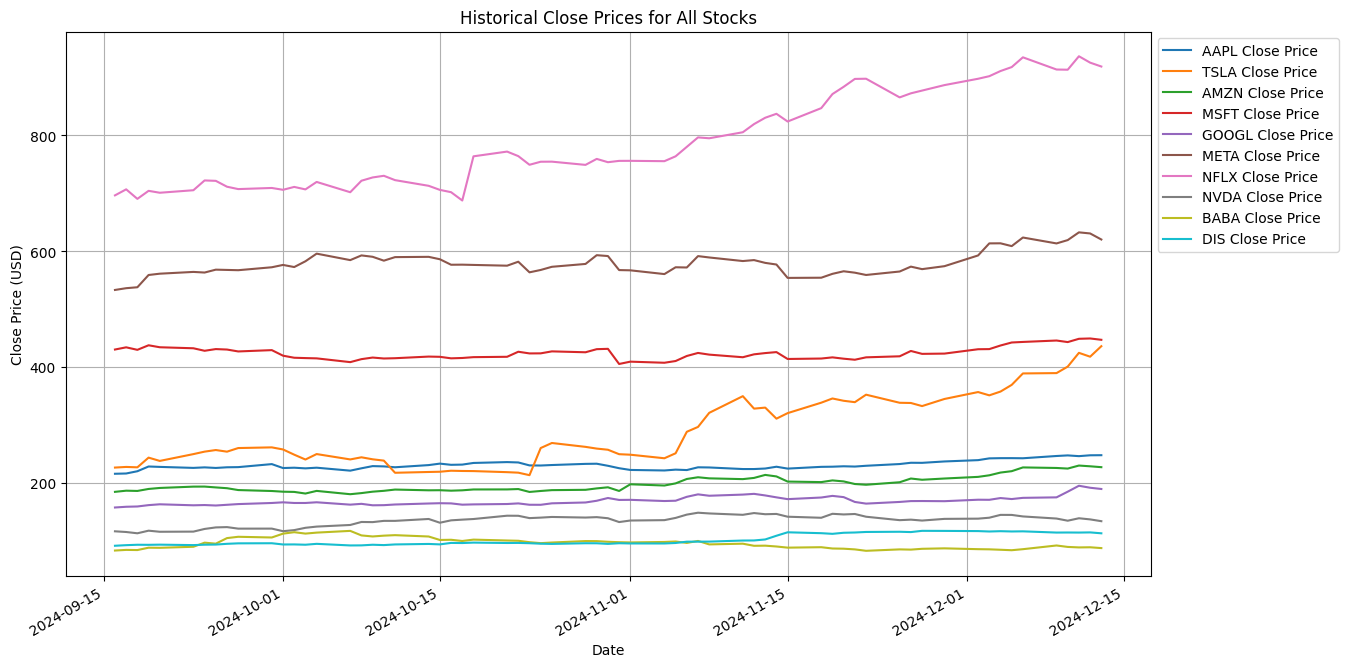

In [8]:

# Combined graph for all stock symbols
plt.figure(figsize=(14, 8))

# Plot each stock's historical close prices in the same figure
for symbol, data in historical_data.items():
    plt.plot(data.index, data['Close'], label=f"{symbol} Close Price")

# Add title, labels, legend, and grid
plt.title("Historical Close Prices for All Stocks")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.grid(True)

# Improve date formatting on the x-axis
plt.gcf().autofmt_xdate()

# Save and display the plot
combined_plot_path = os.path.join(output_dir, "all_stocks_historical_prices.png")
plt.savefig(combined_plot_path, bbox_inches='tight')
plt.show()


# Part 2: Portfolio Tracker

####  Simulate a Portfolio

In [9]:

portfolio = {"AAPL": 10, "TSLA": 5, "AMZN": 8, "MSFT": 15}

In [10]:
# Load real-time data
realtime_df = pd.read_csv(realtime_csv_path)
current_portfolio_value = 0
stock_summary = []

In [11]:
# Calculate current portfolio value
print("Current Portfolio Value:")
for stock, quantity in portfolio.items():
    current_price = realtime_df.loc[realtime_df["Symbol"] == stock, "Current Price"].values[0]
    stock_value = quantity * current_price
    current_portfolio_value += stock_value
    stock_summary.append({"Stock": stock, "Quantity": quantity, "Current Price": current_price, "Total Value": stock_value})
    print(f"{stock}: {quantity} shares x ${current_price:.2f} = ${stock_value:.2f}")


Current Portfolio Value:
AAPL: 10 shares x $248.13 = $2481.30
TSLA: 5 shares x $436.23 = $2181.15
AMZN: 8 shares x $227.46 = $1819.68
MSFT: 15 shares x $447.27 = $6709.05


In [12]:
# Save portfolio summary to CSV
portfolio_df = pd.DataFrame(stock_summary)
portfolio_csv_path = os.path.join(output_dir, "portfolio_summary.csv")
portfolio_df.to_csv(portfolio_csv_path, index=False)

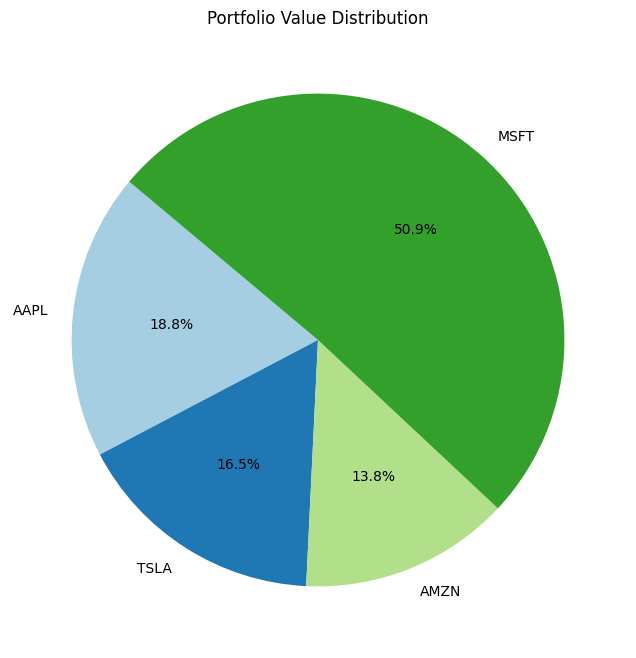

In [13]:
# Enhanced visualization of portfolio distribution
plt.figure(figsize=(8, 8))
labels = portfolio_df["Stock"]
sizes = portfolio_df["Total Value"]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Portfolio Value Distribution")
plt_path = os.path.join(output_dir, "portfolio_distribution.png")
plt.savefig(plt_path)
plt.show()


In [14]:
print(f"Total Portfolio Value: ${current_portfolio_value:.2f}")

Total Portfolio Value: $13191.18


####  Performance Tracking


In [15]:
initial_portfolio_value = 0
performance_summary = []


In [16]:

def format_currency(value):
    return f"${value:.2f}"

print("\nPerformance Tracking:")
for stock, quantity in portfolio.items():
    historical_csv_path = os.path.join(output_dir, f"{stock}_historical.csv")
    historical_df = pd.read_csv(historical_csv_path)
    if not historical_df.empty:
        start_price = historical_df.iloc[0]["Close"]
        current_price = realtime_df.loc[realtime_df["Symbol"] == stock, "Current Price"].values[0]
        initial_value = quantity * start_price
        current_value = quantity * current_price
        percentage_change = ((current_value - initial_value) / initial_value) * 100
        initial_portfolio_value += initial_value
        performance_summary.append({
            "Stock": stock,
            "Initial Price": start_price,
            "Current Price": current_price,
            "Quantity": quantity,
            "Initial Value": initial_value,
            "Current Value": current_value,
            "Percentage Change": percentage_change
        })
        print(f"{stock}: Initial = {format_currency(initial_value)}, Current = {format_currency(current_value)}, Change = {percentage_change:.2f}%")



Performance Tracking:
AAPL: Initial = $2160.82, Current = $2481.30, Change = 14.83%
TSLA: Initial = $1133.90, Current = $2181.15, Change = 92.36%
AMZN: Initial = $1479.12, Current = $1819.68, Change = 23.02%
MSFT: Initial = $6457.17, Current = $6709.05, Change = 3.90%


In [17]:
# Calculate overall portfolio performance
portfolio_percentage_change = ((current_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100
print(f"\nInitial Portfolio Value: {format_currency(initial_portfolio_value)}")
print(f"Current Portfolio Value: {format_currency(current_portfolio_value)}")
print(f"Overall Portfolio Change: {portfolio_percentage_change:.2f}%")


Initial Portfolio Value: $11231.02
Current Portfolio Value: $13191.18
Overall Portfolio Change: 17.45%


In [18]:
# Save performance summary to CSV
performance_df = pd.DataFrame(performance_summary)
performance_csv_path = os.path.join(output_dir, "performance_summary.csv")
performance_df.to_csv(performance_csv_path, index=False)


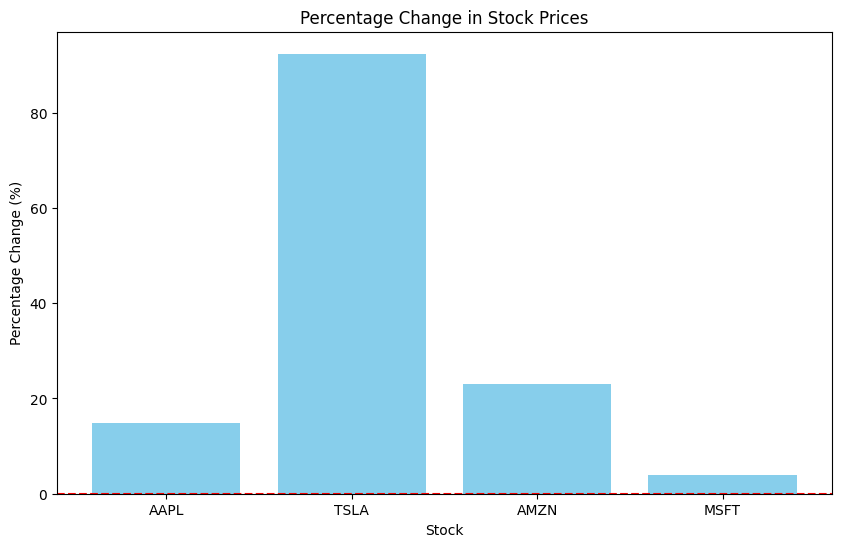

In [19]:
# Visualization of percentage changes
plt.figure(figsize=(10, 6))
stocks = performance_df["Stock"]
changes = performance_df["Percentage Change"]
plt.bar(stocks, changes, color="skyblue")
plt.axhline(0, color="red", linestyle="--")
plt.title("Percentage Change in Stock Prices")
plt.xlabel("Stock")
plt.ylabel("Percentage Change (%)")
plt_path = os.path.join(output_dir, "performance_change_plot.png")
plt.savefig(plt_path)
plt.show()

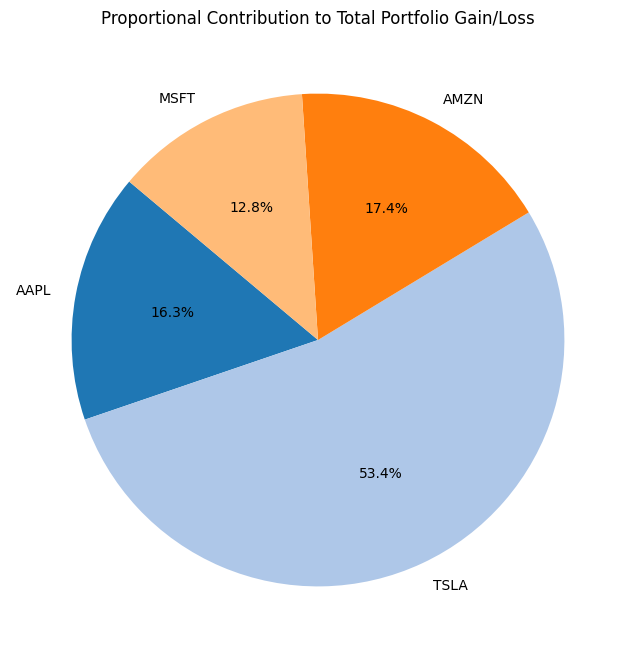

In [20]:
# Pie chart of individual gains/losses
plt.figure(figsize=(8, 8))
gains_losses = [
    (row["Current Value"] - row["Initial Value"]) for _, row in performance_df.iterrows()
]
plt.pie(
    gains_losses,
    labels=performance_df["Stock"],
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.tab20.colors,
)
plt.title("Proportional Contribution to Total Portfolio Gain/Loss")
pie_path = os.path.join(output_dir, "portfolio_gain_loss_distribution.png")
plt.savefig(pie_path)
plt.show()


#### Highlight top and worst performers

In [21]:

top_performer = performance_df.loc[performance_df["Percentage Change"].idxmax()]
worst_performer = performance_df.loc[performance_df["Percentage Change"].idxmin()]
print(f"Top Performer: {top_performer['Stock']} with {top_performer['Percentage Change']:.2f}% gain.")
print(f"Worst Performer: {worst_performer['Stock']} with {worst_performer['Percentage Change']:.2f}% loss.")



Top Performer: TSLA with 92.36% gain.
Worst Performer: MSFT with 3.90% loss.


# Part 3: Trade Analyzer

###   Trade Signal Generation (Moving Average Crossover Strategy)

In [22]:


def generate_trade_signals(stock_symbol, historical_data):
    historical_data["5_day_MA"] = historical_data["Close"].rolling(window=5).mean()
    historical_data["20_day_MA"] = historical_data["Close"].rolling(window=20).mean()
    
    
    signals = []
    """
Generate trade signals based on moving average crossover.
Args:
    stock_symbol (str): Stock symbol.
    historical_data (DataFrame): Historical price data.
Returns:
    List[Dict]: List of trade signals.
"""
    for i in range(1, len(historical_data)):
        if historical_data["5_day_MA"].iloc[i] > historical_data["20_day_MA"].iloc[i] and historical_data["5_day_MA"].iloc[i-1] <= historical_data["20_day_MA"].iloc[i-1]:
            signals.append({"Date": historical_data.index[i], "Symbol": stock_symbol, "Signal": "BUY"})
        elif historical_data["5_day_MA"].iloc[i] < historical_data["20_day_MA"].iloc[i] and historical_data["5_day_MA"].iloc[i-1] >= historical_data["20_day_MA"].iloc[i-1]:
            signals.append({"Date": historical_data.index[i], "Symbol": stock_symbol, "Signal": "SELL"})
    
    return signals


In [23]:
# Generate trade signals for all stocks
trade_signals = []
for symbol in stock_symbols:
    historical_csv_path = os.path.join(output_dir, f"{symbol}_historical.csv")
    historical_df = pd.read_csv(historical_csv_path, parse_dates=["Date"], index_col="Date")
    if not historical_df.empty:
        signals = generate_trade_signals(symbol, historical_df)
        trade_signals.extend(signals)


In [24]:
# Save trade signals to CSV
trade_signals_df = pd.DataFrame(trade_signals)
trade_signals_csv_path = os.path.join(output_dir, "trade_signals.csv")
trade_signals_df.to_csv(trade_signals_csv_path, index=False)


In [25]:
# Output trade signals
print("Generated Trade Signals:")
print(trade_signals_df)

Generated Trade Signals:
                         Date Symbol Signal
0   2024-11-01 00:00:00-04:00   AAPL   SELL
1   2024-11-20 00:00:00-05:00   AAPL    BUY
2   2024-10-28 00:00:00-04:00   TSLA    BUY
3   2024-10-17 00:00:00-04:00   AMZN    BUY
4   2024-11-22 00:00:00-05:00   AMZN   SELL
5   2024-12-02 00:00:00-05:00   AMZN    BUY
6   2024-10-23 00:00:00-04:00   MSFT    BUY
7   2024-11-04 00:00:00-05:00   MSFT   SELL
8   2024-11-12 00:00:00-05:00   MSFT    BUY
9   2024-11-18 00:00:00-05:00   MSFT   SELL
10  2024-11-26 00:00:00-05:00   MSFT    BUY
11  2024-10-16 00:00:00-04:00  GOOGL    BUY
12  2024-10-22 00:00:00-04:00  GOOGL   SELL
13  2024-10-28 00:00:00-04:00  GOOGL    BUY
14  2024-11-21 00:00:00-05:00  GOOGL   SELL
15  2024-12-09 00:00:00-05:00  GOOGL    BUY
16  2024-10-21 00:00:00-04:00   META   SELL
17  2024-11-11 00:00:00-05:00   META    BUY
18  2024-11-15 00:00:00-05:00   META   SELL
19  2024-12-02 00:00:00-05:00   META    BUY
20  2024-10-17 00:00:00-04:00   NFLX   SELL
21  202

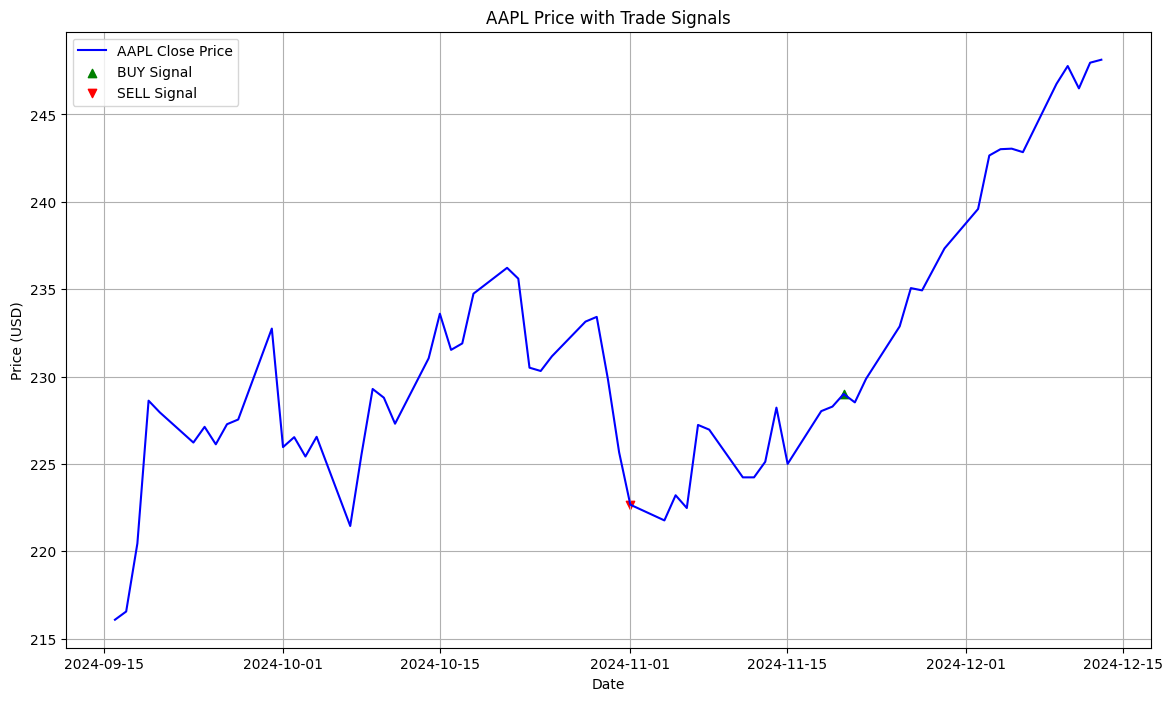

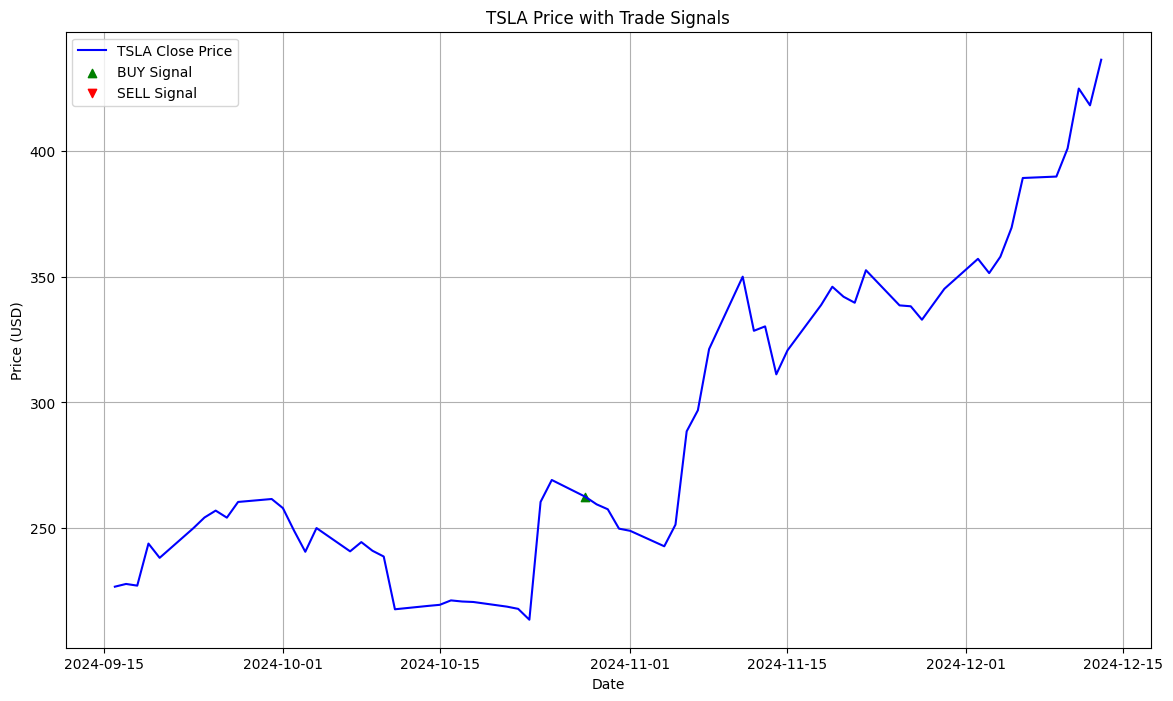

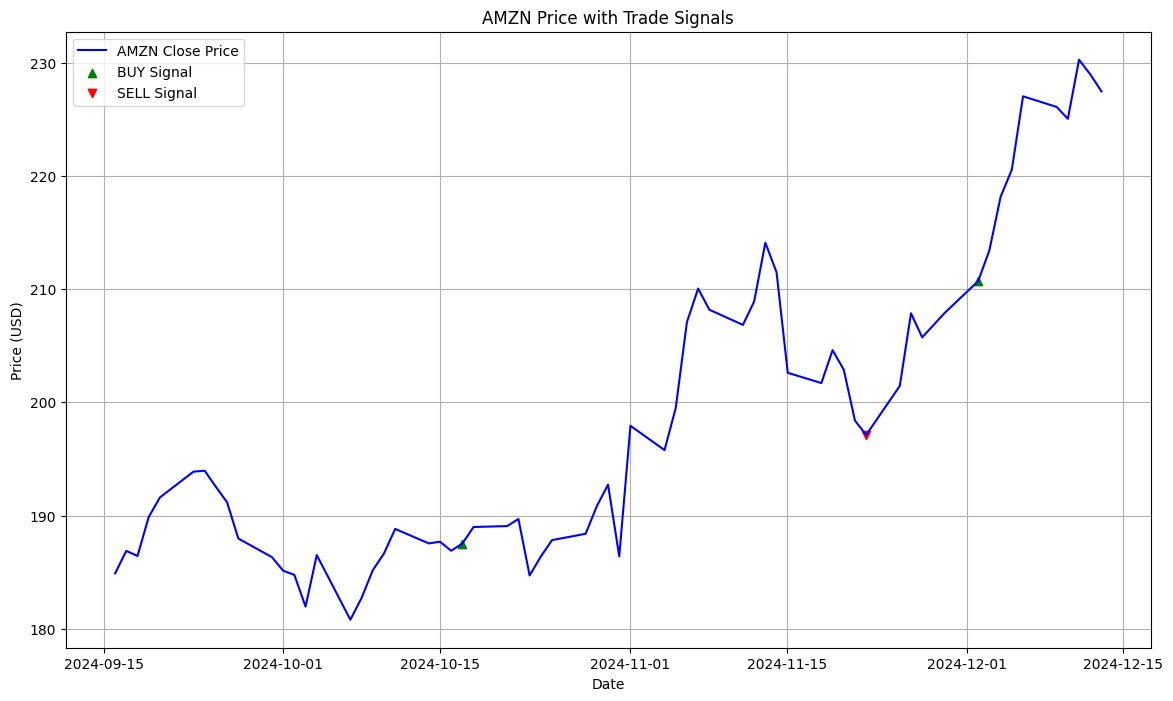

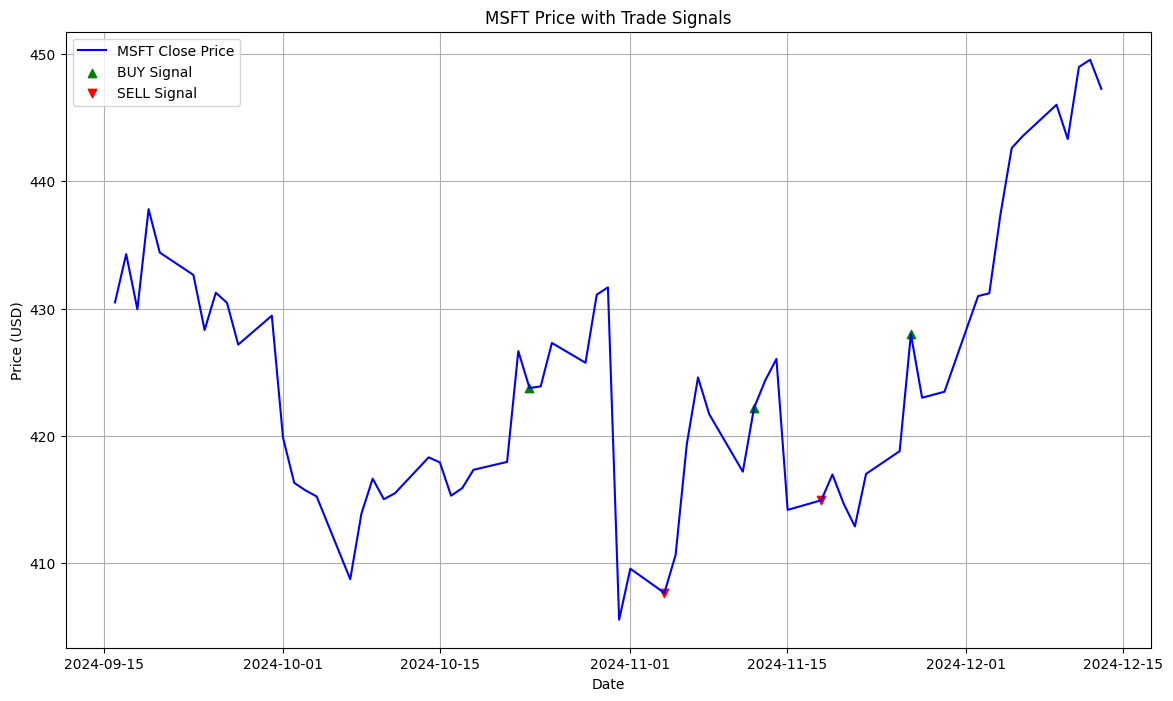

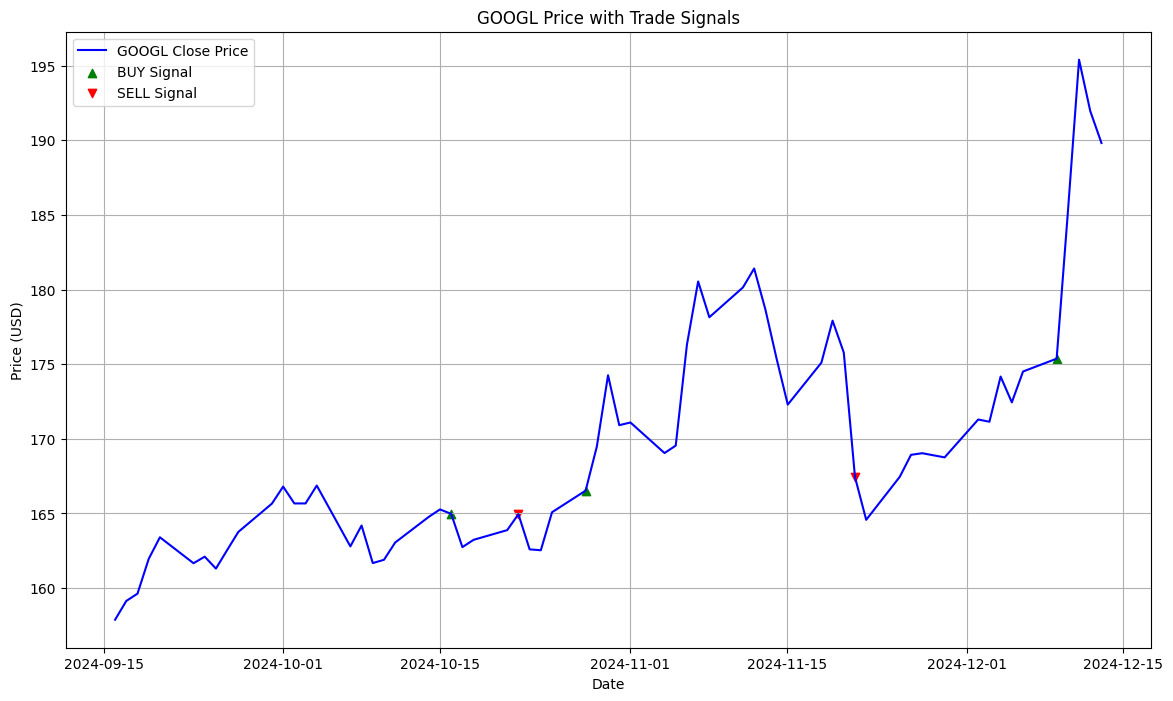

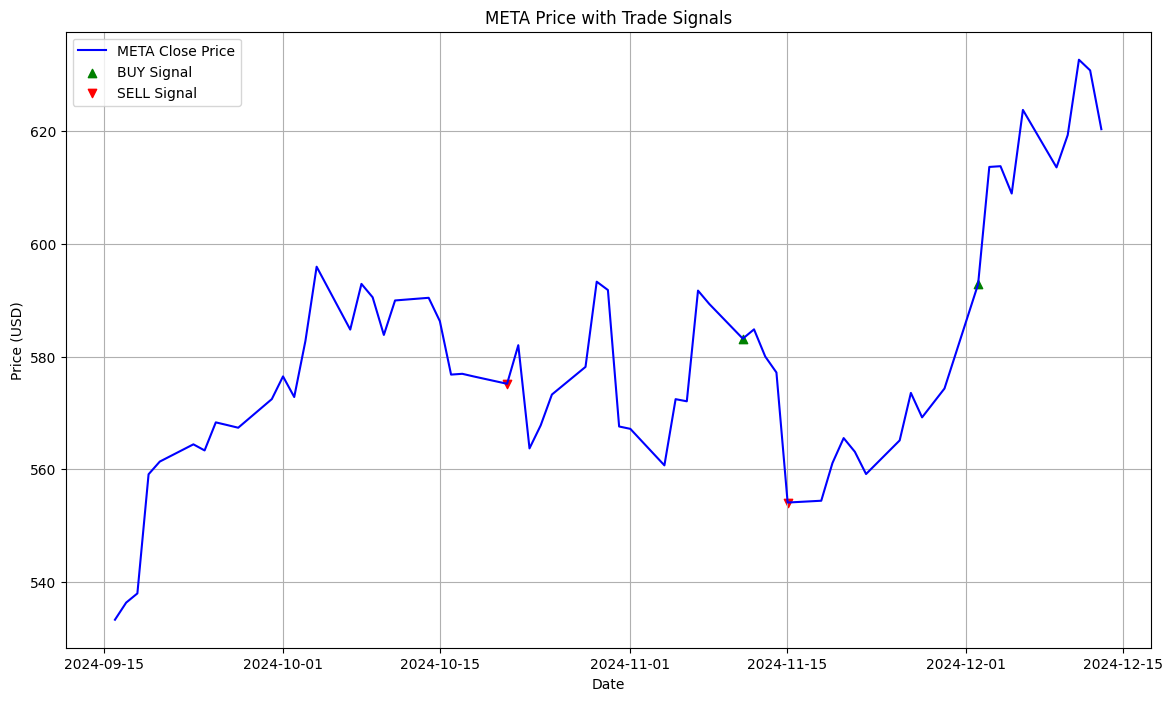

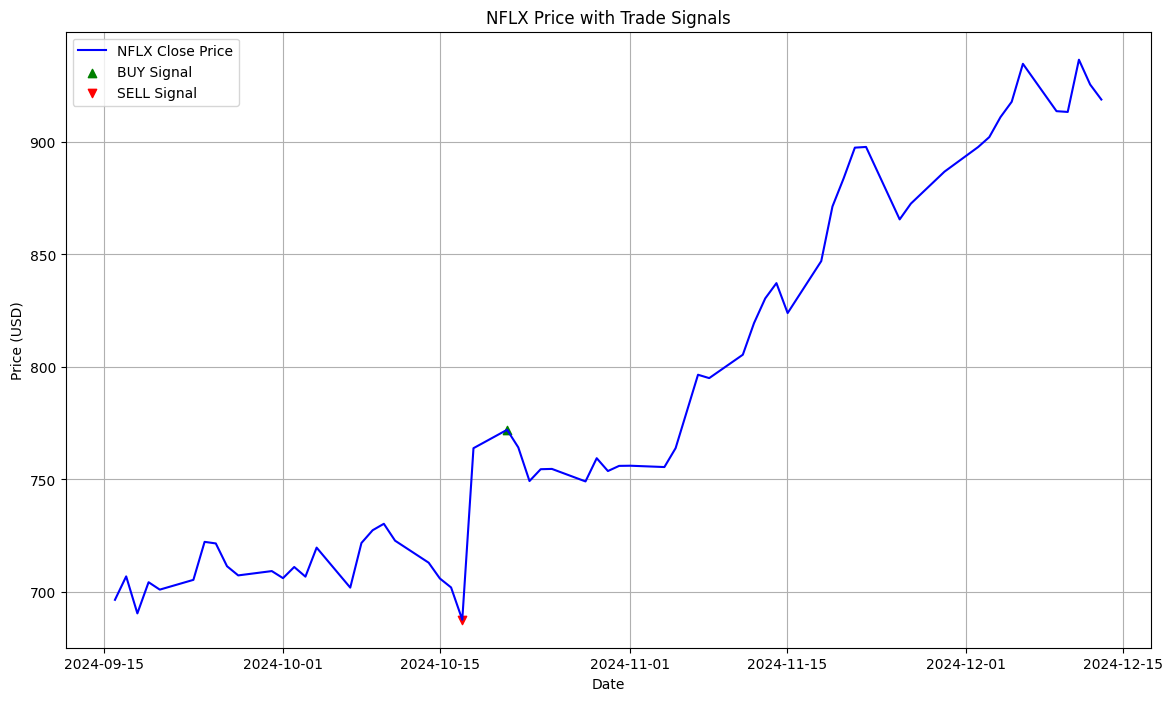

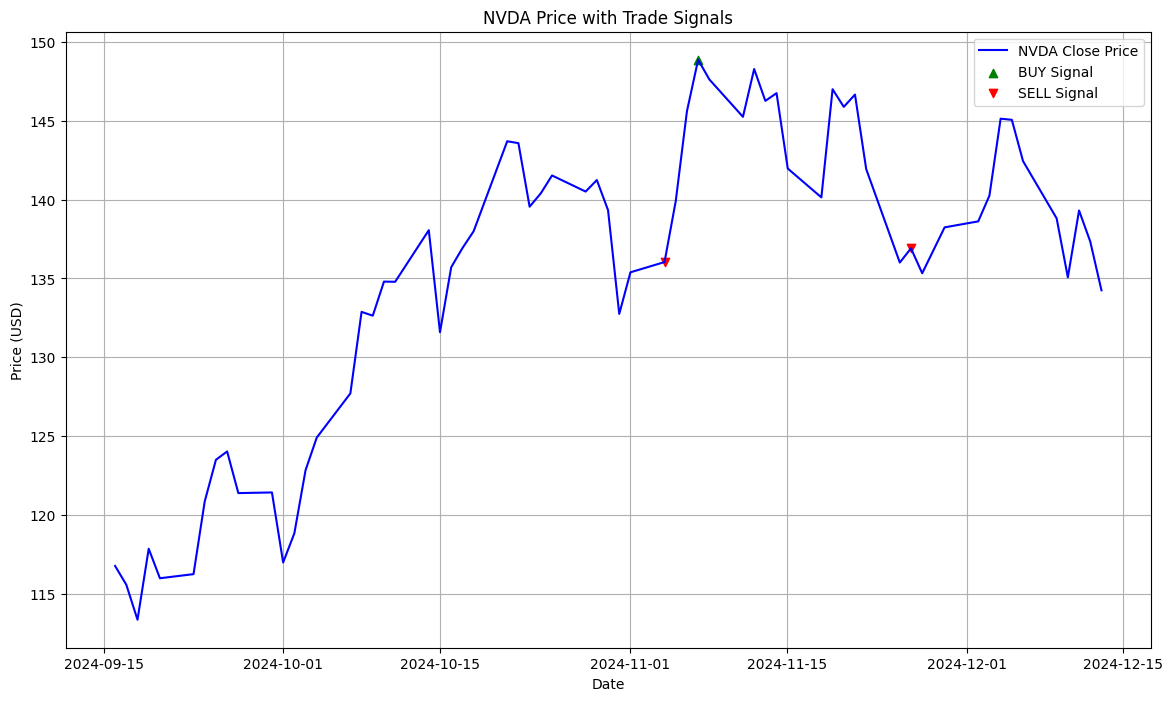

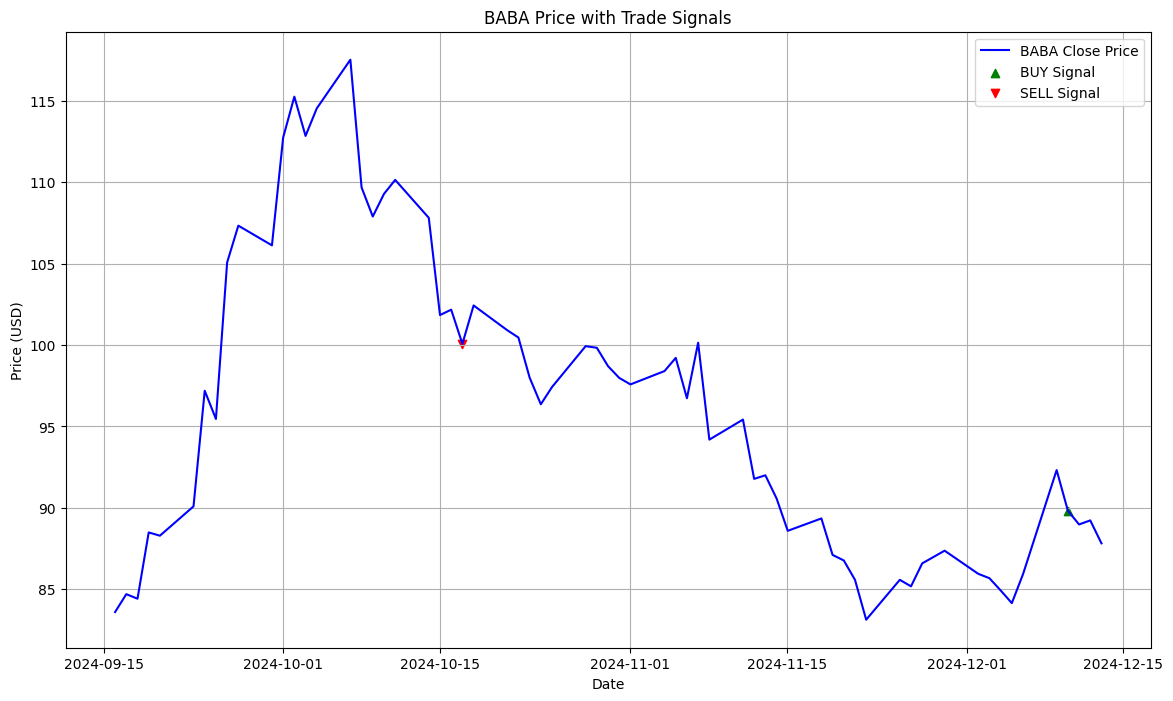

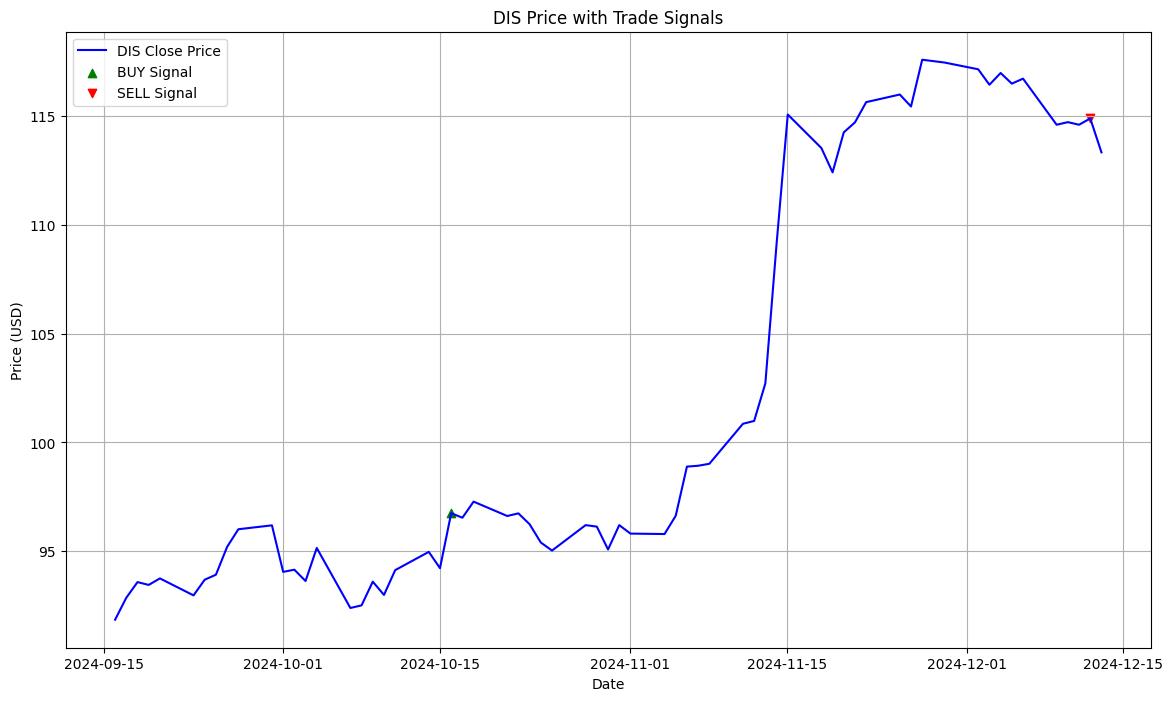

In [27]:
for symbol in stock_symbols:
    historical_csv_path = os.path.join(output_dir, f"{symbol}_historical.csv")
    historical_df = pd.read_csv(historical_csv_path, parse_dates=["Date"], index_col="Date")

    signals = trade_signals_df[trade_signals_df["Symbol"] == symbol]

    plt.figure(figsize=(14, 8))
    plt.plot(historical_df.index, historical_df["Close"], label=f"{symbol} Close Price", color="blue")

    # Highlight BUY and SELL signals
    buy_signals = signals[signals["Signal"] == "BUY"]
    sell_signals = signals[signals["Signal"] == "SELL"]

    plt.scatter(
        buy_signals["Date"],
        historical_df.loc[buy_signals["Date"], "Close"],
        marker="^",
        color="green",
        label="BUY Signal",
    )
    plt.scatter(
        sell_signals["Date"],
        historical_df.loc[sell_signals["Date"], "Close"],
        marker="v",
        color="red",
        label="SELL Signal",
    )

    plt.title(f"{symbol} Price with Trade Signals")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt_path = os.path.join(output_dir, f"{symbol}_trade_signals_plot.png")
    plt.savefig(plt_path, bbox_inches="tight")
    plt.show()


### Trade History Simulation (Simulating Trades based on signals)


In [26]:
initial_capital = 10000
capital = initial_capital
portfolio_simulation = {symbol: 0 for symbol in stock_symbols}  # Track the number of shares owned for each stock

#  simulate a trade
def simulate_trade(signal, capital, portfolio, historical_data):
    action = signal["Signal"]
    date = signal["Date"]
    symbol = signal["Symbol"]
    price = historical_data.loc[date, "Close"]
    
    if action == "BUY":
        if capital >= price:
            quantity = capital // price
            capital -= quantity * price
            portfolio[symbol] += quantity
            print(f"BUY {quantity} {symbol} at {price} on {date}")
    elif action == "SELL":
        if portfolio[symbol] > 0:
            quantity = portfolio[symbol]
            capital += quantity * price
            portfolio[symbol] = 0
            print(f"SELL {quantity} {symbol} at {price} on {date}")
    
    return capital, portfolio

# Simulate the trades for each signal
for signal in trade_signals:
    historical_csv_path = os.path.join(output_dir, f"{signal['Symbol']}_historical.csv")
    historical_df = pd.read_csv(historical_csv_path, parse_dates=["Date"], index_col="Date")
    if not historical_df.empty:
        date = signal["Date"]
        price = historical_df.loc[date, "Close"]
        capital, portfolio_simulation = simulate_trade(signal, capital, portfolio_simulation, historical_df)

# Final Portfolio Value and Capital
final_portfolio_value = 0
for symbol, quantity in portfolio_simulation.items():
    if quantity > 0:
        current_price = pd.read_csv(os.path.join(output_dir, f"{symbol}_historical.csv")).iloc[-1]["Close"]
        final_portfolio_value += quantity * current_price

final_capital = capital + final_portfolio_value

print(f"\nInitial Capital: {initial_capital}")
print(f"Final Capital: {capital}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Final Capital + Portfolio Value: {final_capital}")

# Save final capital and portfolio value to CSV
final_report = {
    "Initial Capital": initial_capital,
    "Final Capital": capital,
    "Final Portfolio Value": final_portfolio_value,
    "Total Final Value": final_capital
}
final_report_df = pd.DataFrame([final_report])
final_report_csv_path = os.path.join(output_dir, "final_report.csv")
final_report_df.to_csv(final_report_csv_path, index=False)

# Final Portfolio Summary
portfolio_summary_df = pd.DataFrame([(symbol, quantity) for symbol, quantity in portfolio_simulation.items()], columns=["Stock", "Quantity"])
portfolio_summary_csv_path = os.path.join(output_dir, "final_portfolio_summary.csv")
portfolio_summary_df.to_csv(portfolio_summary_csv_path, index=False)

BUY 43.0 AAPL at 229.0 on 2024-11-20 00:00:00-05:00
BUY 1.0 NVDA at 148.8697509765625 on 2024-11-07 00:00:00-05:00
SELL 1.0 NVDA at 136.9105682373047 on 2024-11-26 00:00:00-05:00
BUY 1.0 BABA at 89.83000183105469 on 2024-12-10 00:00:00-05:00

Initial Capital: 10000
Final Capital: 51.2108154296875
Final Portfolio Value: 10757.410209655762
Total Final Capital + Portfolio Value: 10808.62102508545
